# This notebook classifies cavity of teeth

In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import shutil
import cv2
from tqdm.auto import tqdm

C:\Users\bansal\Anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The Datasets are taken from the following Links and saved to the folder named **zip_datasets**

- https://www.kaggle.com/datasets/nabeel1921/dental-cavity

- https://zenodo.org/record/4907880

- https://www.kaggle.com/datasets/salmansajid05/oral-diseases

- https://www.kaggle.com/datasets/pushkar34/teeth-dataset

In [89]:
CWD = os.getcwd()

In [25]:
os.listdir('zip_datasets')

['archive.zip', 'archive_2.zip', 'archive_3.zip', 'Dental Cavity Dataset.zip']

In [8]:
os.mkdir('unzipped_datasets')

There can be a naming problem in one of the Zips, Please remove the space in the folder name if error occurs

In [30]:
for path_to_dataset in os.listdir('zip_datasets'):
    path_to_dataset = os.path.join(os.path.join(CWD,'zip_datasets'),path_to_dataset)
    with zipfile.ZipFile(path_to_dataset, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(CWD,'unzipped_datasets'))

In [2]:
os.listdir('unzipped_datasets')

['Calculus',
 'Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset',
 'Data caries',
 'Dataset',
 'Gingivitis',
 'hypodontia',
 'Mouth Ulcer',
 'teeth_dataset',
 'test',
 'Tooth Discoloration',
 'train']

 - **Caries_Gingivitus_ToothDiscoloration_Ulcer-yolo_annotated-Dataset** and **Dataset** are annotated as bounding boxes
 - **Data caries , teeth_dataset, test, train**  can be used for classifiaction

# Let's work on classification of Dental images containing cavities 

In [31]:
Folders_path_cavity = ['unzipped_datasets\\Data caries\\Data caries\\caries orignal data set\\done',
                'unzipped_datasets\\teeth_dataset\\teeth_dataset\\test\\caries',
                'unzipped_datasets\\teeth_dataset\\teeth_dataset\\Trianing\\caries',
                'unzipped_datasets\\test\\cavity',
                'unzipped_datasets\\train\\cavity',
               ]
Folders_path_no_cavity = [
    'unzipped_datasets\\teeth_dataset\\teeth_dataset\\test\\no-caries',
    'unzipped_datasets\\teeth_dataset\\teeth_dataset\\Trianing\\without_caries',
    'unzipped_datasets\\test\\no_cavity',
    'unzipped_datasets\\train\\no_cavity',
]

### Few Images in **Data caries** Folder

In [50]:
def plot_images_from_folder(folder):
    plt.rcParams["figure.figsize"] = [10, 2]
    fig, ax = plt.subplots(nrows=1, ncols=4)
    plt.suptitle(f'Images from {folder} Dataset')
    for i,src in enumerate(os.listdir(folder)[:4]):
        src = f'{folder}\\{src}'
        image = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)
        ax[i].axis('off')
        ax[i].imshow(image)
    plt.show()

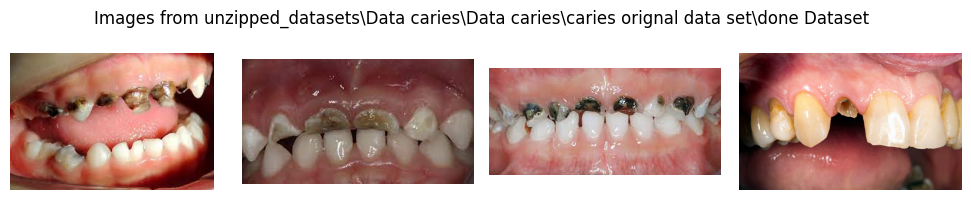

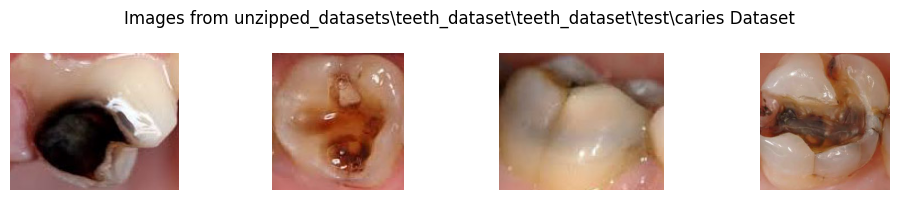

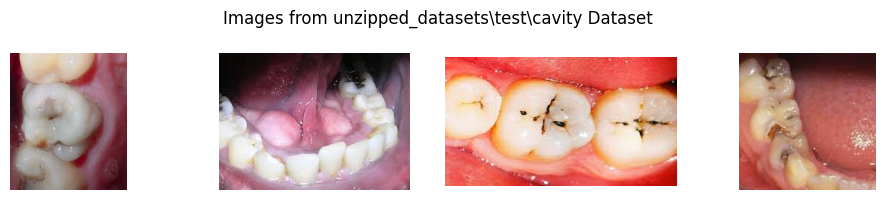

In [52]:
plot_images_from_folder(Folders_path_cavity[0])
plot_images_from_folder(Folders_path_cavity[1])
plot_images_from_folder(Folders_path_cavity[3])

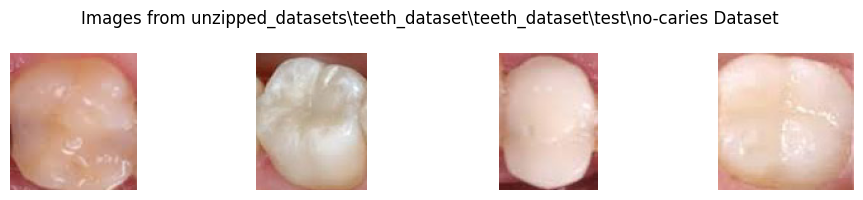

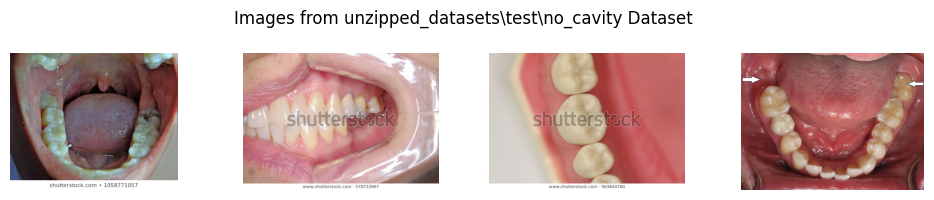

In [53]:
plot_images_from_folder(Folders_path_no_cavity[0])
plot_images_from_folder(Folders_path_no_cavity[2])

In [5]:
os.mkdir('Classification_dataset')

In [14]:
os.mkdir('Classification_dataset\\train')
os.mkdir('Classification_dataset\\test')
os.mkdir('Classification_dataset\\test\\cavity')
os.mkdir('Classification_dataset\\test\\no_cavity')
os.mkdir('Classification_dataset\\train\\cavity')
os.mkdir('Classification_dataset\\train\\no_cavity')

In [56]:
for Folder in Folders_path_cavity:
    Folder_name = Folder.split("\\")[-1]
    for src in os.listdir(Folder):
        dst = f'Classification_dataset\\train\\cavity\\{Folder_name}_{src}'
        src = f'{Folder}\\{src}'
        shutil.copyfile(src, dst)

In [57]:
for Folder in Folders_path_no_cavity:
    Folder_name = Folder.split("\\")[-1]
    for src in os.listdir(Folder):
        dst = f'Classification_dataset\\train\\no_cavity\\{Folder_name}_{src}'
        src = f'{Folder}\\{src}'
        shutil.copyfile(src, dst)

In [62]:
print('Cavity Images',len(os.listdir('Classification_dataset\\train\\cavity')))
print('Non Cavity Images',len(os.listdir('Classification_dataset\\train\\no_cavity')))

Cavity Images 760
Non Cavity Images 417


### Let's Split Dataset Train 60% Test 40%

In [83]:
choices_cavity = sorted(np.random.choice(os.listdir('Classification_dataset\\train\\cavity'),int(len(os.listdir('Classification_dataset\\train\\cavity'))*0.4),replace = False))
for i in choices_cavity:
    src = f'Classification_dataset\\train\\cavity\\{i}'
    dst = f'Classification_dataset\\test\\cavity\\{i}'
    shutil.move(src,dst)

In [84]:
choices_cavity = sorted(np.random.choice(os.listdir('Classification_dataset\\train\\no_cavity'),int(len(os.listdir('Classification_dataset\\train\\no_cavity'))*0.4),replace = False))
for i in choices_cavity:
    src = f'Classification_dataset\\train\\no_cavity\\{i}'
    dst = f'Classification_dataset\\test\\no_cavity\\{i}'
    shutil.move(src,dst)

In [85]:
print('Cavity Train Images',len(os.listdir('Classification_dataset\\train\\cavity')))
print('Non Cavity Train Images',len(os.listdir('Classification_dataset\\train\\no_cavity')))
print('Cavity Test Images',len(os.listdir('Classification_dataset\\test\\cavity')))
print('Non Cavity Test Images',len(os.listdir('Classification_dataset\\test\\no_cavity')))

Cavity Train Images 456
Non Cavity Train Images 251
Cavity Test Images 304
Non Cavity Test Images 166


# Let's Use Pytorch for classification

In [286]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary
from torchvision import datasets
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryF1Score

from pathlib import Path
from timeit import default_timer as timer
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


torchvision.__version__ , torch.__version__

('0.15.2+cu118', '2.0.1+cu118')

In [104]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [92]:
data_path = Path("")

In [94]:
image_path = data_path / "Classification_dataset"
train_dir = image_path / "train"
test_dir = image_path / "test"

### Can Add More Data Augmentations

In [267]:
train_transforms_v1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), 
    
])
test_transform_v1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

In [126]:
train_data = datasets.ImageFolder(root=train_dir,transform=train_transforms_v1)
test_data = datasets.ImageFolder(root=test_dir,transform=test_transform_v1)

In [127]:
train_data.classes

['cavity', 'no_cavity']

In [128]:
test_data.classes

['cavity', 'no_cavity']

In [268]:
BATCH_SIZE=32
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)

In [269]:
img, label = next(iter(test_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


In [270]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*2809,out_features=output_shape),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

model_v1 = TinyVGG(3,10,1).to(device)

In [271]:
summary(model_v1, input_size=img.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 10, 110, 110]        --
│    └─Conv2d: 2-1                       [32, 10, 222, 222]        280
│    └─ReLU: 2-2                         [32, 10, 222, 222]        --
│    └─Conv2d: 2-3                       [32, 10, 220, 220]        910
│    └─ReLU: 2-4                         [32, 10, 220, 220]        --
│    └─MaxPool2d: 2-5                    [32, 10, 110, 110]        --
├─Sequential: 1-2                        [32, 10, 53, 53]          --
│    └─Conv2d: 2-6                       [32, 10, 108, 108]        910
│    └─ReLU: 2-7                         [32, 10, 108, 108]        --
│    └─Conv2d: 2-8                       [32, 10, 106, 106]        910
│    └─ReLU: 2-9                         [32, 10, 106, 106]        --
│    └─MaxPool2d: 2-10                   [32, 10, 53, 53]          --
├─Sequentia

In [272]:
def print_train_time(start,end,device):
    total_time = end-start
    print(f'Train tome on {device}: {total_time:.3f} seconds')
    return total_time

In [273]:
# def accuracy_fn(y_true,y_pred):
#     correct = torch.eq(y_true,y_pred).sum().item()
#     acc = (correct/len(y_pred))*100
#     return acc

In [279]:
def train_step(model,dataloader,loss_fn,optimizer,device,accuracy_fn=None):
    model.train()
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
        y = y.float()
        y_pred = model(X)
#         print(y_pred,y)
        loss = loss_fn(torch.squeeze(y_pred),y)
        train_loss+=loss.item()
        if accuracy_fn:
            train_acc+=accuracy_fn(torch.squeeze(y_pred),y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss/=len(dataloader)
    train_acc/=len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.4f}% |", end = " ")
    return train_loss,train_acc

In [280]:
def test_step(model,dataloader,loss_fn,device,accuracy_fn=None):
    model.eval() 
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y = y.float()
            test_pred_logits = model(X)
            loss = loss_fn(torch.squeeze(test_pred_logits),y)
            test_loss += loss.item()
            if accuracy_fn:
                test_acc+=accuracy_fn(torch.squeeze(test_pred_logits),y)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")
    return test_loss, test_acc

In [281]:
def train(model, train_dataloader, test_dataloader,loss_fn,optimizer,epochs=5,device='cpu',accuracy_fn=None,seed=42):
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    results={"train_loss":[],"train_acc":[],"test_loss":[],"test_acc":[]}
    for epoch in range(epochs):
        print("Epoch: ",epoch,end = " ")
        train_loss,train_acc = train_step(model,train_dataloader,loss_fn,optimizer,device,accuracy_fn)
        test_loss,test_acc = test_step(model,test_dataloader,loss_fn,device,accuracy_fn)
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    return results

In [282]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model_v1.parameters())

Using F1 Score for accuracy

In [284]:
results = train(model_v1,train_dataloader,test_dataloader,loss_fn,optimizer,epochs=100,device=device,accuracy_fn=BinaryF1Score().to(device))

Epoch:  0 Train loss: 0.35576 | Train acc: 0.7284% | Test loss: 0.6684 | Test acc: 0.51%
Epoch:  1 Train loss: 0.31440 | Train acc: 0.7862% | Test loss: 0.6792 | Test acc: 0.51%
Epoch:  2 Train loss: 0.28986 | Train acc: 0.8132% | Test loss: 0.7486 | Test acc: 0.54%
Epoch:  3 Train loss: 0.32942 | Train acc: 0.7617% | Test loss: 0.7216 | Test acc: 0.52%
Epoch:  4 Train loss: 0.39695 | Train acc: 0.7103% | Test loss: 0.6681 | Test acc: 0.51%
Epoch:  5 Train loss: 0.36785 | Train acc: 0.7043% | Test loss: 0.6821 | Test acc: 0.40%
Epoch:  6 Train loss: 0.39192 | Train acc: 0.6965% | Test loss: 0.6540 | Test acc: 0.59%
Epoch:  7 Train loss: 0.37046 | Train acc: 0.7202% | Test loss: 0.6779 | Test acc: 0.50%
Epoch:  8 Train loss: 0.38897 | Train acc: 0.7332% | Test loss: 0.6130 | Test acc: 0.52%
Epoch:  9 Train loss: 0.27747 | Train acc: 0.7641% | Test loss: 0.8019 | Test acc: 0.58%
Epoch:  10 Train loss: 0.25350 | Train acc: 0.8014% | Test loss: 0.7979 | Test acc: 0.56%
Epoch:  11 Train los

Epoch:  91 Train loss: 0.00024 | Train acc: 0.9565% | Test loss: 5.0858 | Test acc: 0.56%
Epoch:  92 Train loss: 0.00021 | Train acc: 1.0000% | Test loss: 5.3040 | Test acc: 0.56%
Epoch:  93 Train loss: 0.00020 | Train acc: 1.0000% | Test loss: 4.5610 | Test acc: 0.57%
Epoch:  94 Train loss: 0.00020 | Train acc: 0.9565% | Test loss: 5.2024 | Test acc: 0.56%
Epoch:  95 Train loss: 0.00020 | Train acc: 1.0000% | Test loss: 5.1262 | Test acc: 0.57%
Epoch:  96 Train loss: 0.00019 | Train acc: 0.9565% | Test loss: 5.1547 | Test acc: 0.56%
Epoch:  97 Train loss: 0.00019 | Train acc: 1.0000% | Test loss: 5.1705 | Test acc: 0.56%
Epoch:  98 Train loss: 0.00017 | Train acc: 0.9565% | Test loss: 5.2799 | Test acc: 0.56%
Epoch:  99 Train loss: 0.00016 | Train acc: 1.0000% | Test loss: 5.4267 | Test acc: 0.57%


## Test results

In [288]:
y_preds = []
model_v1.eval()
Y = []
with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device),y.to(device)
        y_logit = model_v1(X)
        y_pred = y_logit.squeeze()
        y_preds.append(y_pred.cpu())
        Y.append(y)
#print(y_preds)
y_pred_tensor = torch.cat(y_preds) #list of tensors to single tensor
true_y = torch.cat(Y)

 53%|████████████████████████████████████████████▎                                      | 8/15 [00:02<00:01,  3.65it/s]C:\Users\bansal\Anaconda3\envs\torch\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.29it/s]


In [308]:
for k in zip(y_pred_tensor,true_y):
    if k[0].item()>0.5:
        print(1,k[1].item())
    else:
        print(0,k[1].item())

1 0
1 1
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 0
0 0
1 1
0 1
0 0
0 0
0 0
0 0
1 1
1 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 1
0 0
0 0
1 1
1 0
0 0
1 0
1 1
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
1 1
0 0
0 1
0 0
0 0
1 1
0 0
1 1
1 1
1 0
1 1
0 0
0 0
0 0
0 0
1 0
1 1
0 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
0 0
0 1
0 0
0 0
0 1
1 1
0 1
0 0
0 1
0 0
1 1
0 0
1 0
1 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
1 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 1
1 1
0 0
0 0
0 1
0 1
0 1
0 1
0 1
1 1
0 1
0 0
0 1
0 0
0 0
0 1
1 1
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 0
1 1
1 1
0 0
1 0
0 0
0 0
1 1
0 0
1 0
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 0
0 0
1 1
0 1
0 0
0 0
0 0
1 0
1 0
0 0
0 0
0 1
0 0
0 0
1 1
0 0
1 0
0 0
0 1
0 0
1 1
0 0
1 1
0 0
0 0
1 0
1 1
1 0
0 0
0 0
0 0
0 0
0 0
1 0
0 1
0 0
1 0
0 0
0 0
1 1
1 0
1 1
0 0
0 0
0 0
1 0
0 1
0 1
0 0
0 0
0 0
1 1
1 1
0 0
1 0
0 1
1 1
0 1
1 1
0 0
1 1
0 0
0 0
0 0
0 1
0 0
1 0
1 1
0 0
1 1
1 0
1 0
0 1
1 1
0 0
1 0
1 1
0 1
0 1
0 0


In [302]:
confmat = ConfusionMatrix(task='binary',num_classes=2)
confmat_tensor = confmat(preds = y_pred_tensor, target = true_y.to(device='cpu'))

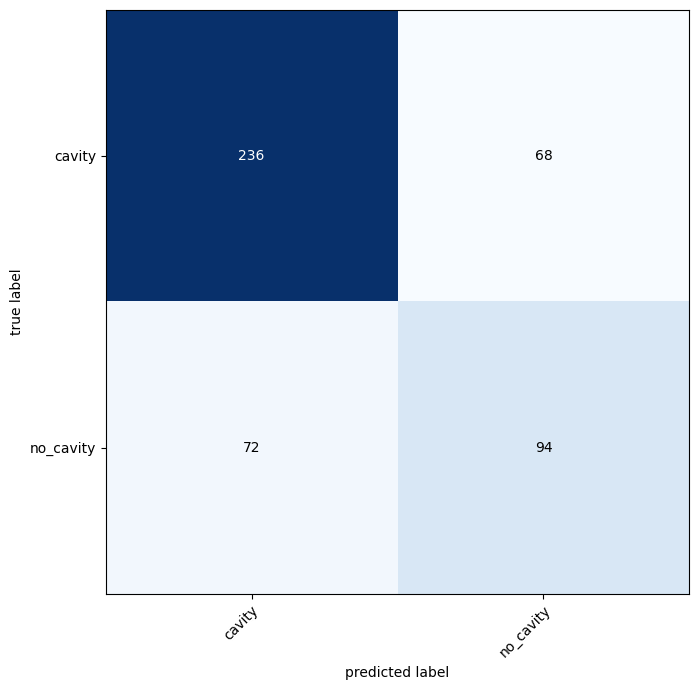

In [304]:
fig,ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10,7)
)

In [330]:
train_data.classes

['cavity', 'no_cavity']

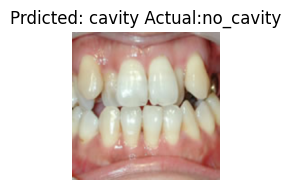

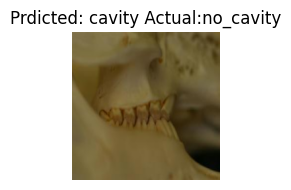

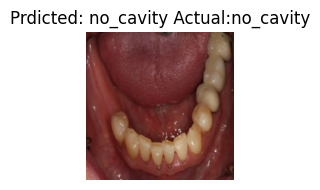

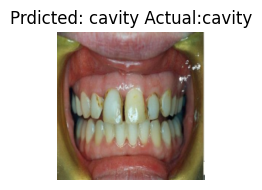

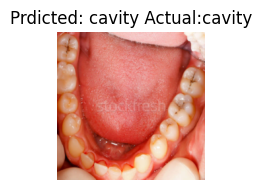

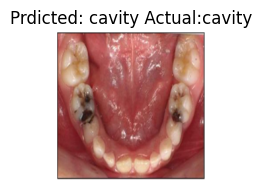

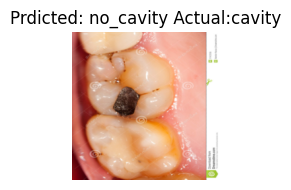

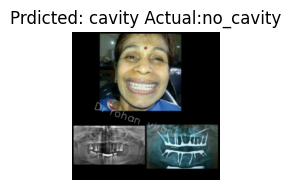

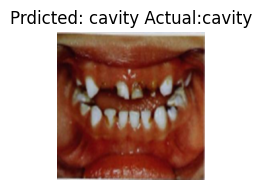

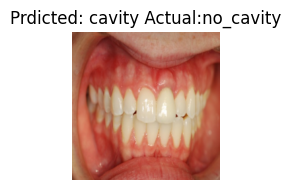

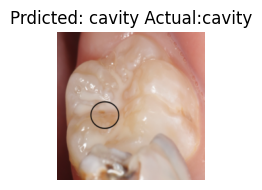

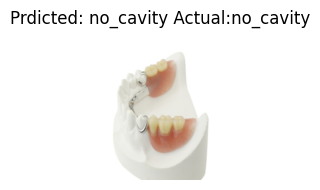

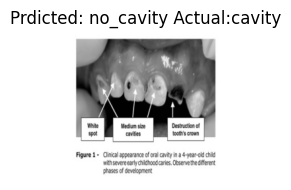

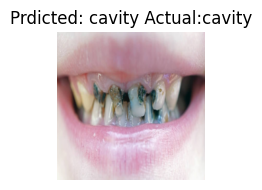

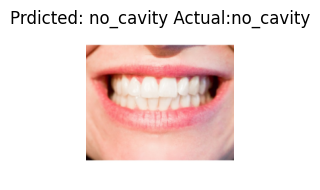

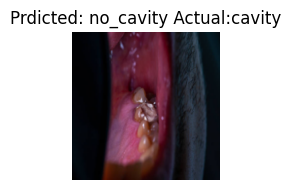

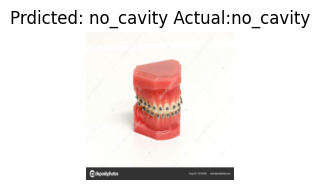

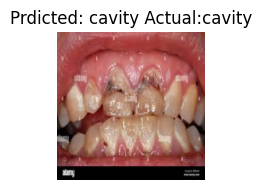

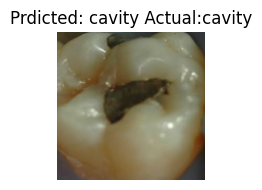

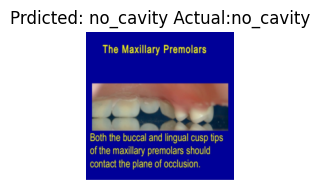

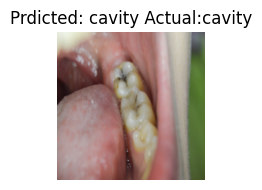

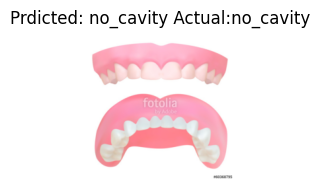

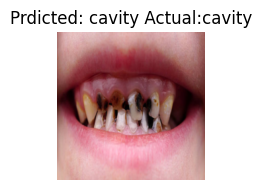

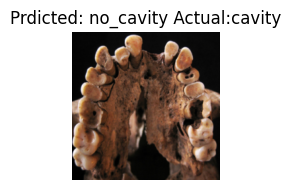

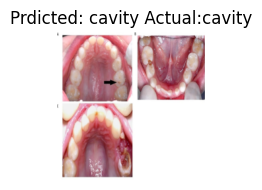

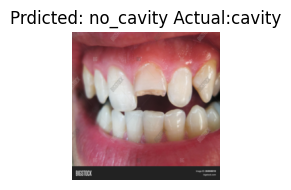

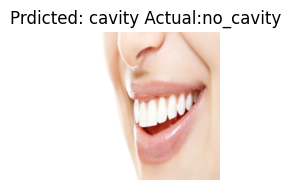

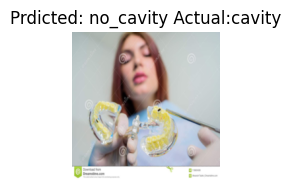

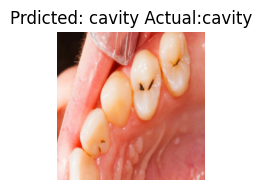

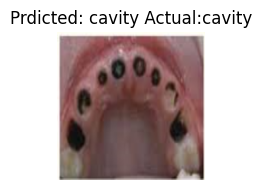

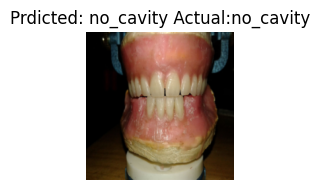

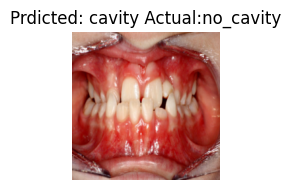

In [342]:
model_v1.eval()
with torch.inference_mode():
    X, y = next(iter(test_dataloader))
    X,y = X.to(device),y.to(device)
    y_logit = model_v1(X)
    y_pred = y_logit.squeeze()
    for i,m in enumerate(X):
        plt.imshow(m.permute(1, 2, 0).cpu())
        if y_pred[i].item()>0.5:
            plt.title("Prdicted: no_cavity Actual:"+str(test_data.classes[y[i].item()]))
        else:
            plt.title("Prdicted: cavity Actual:"+str(test_data.classes[y[i].item()]))
        plt.axis('off')
        plt.show()
    

## Train results

In [309]:
y_preds = []
model_v1.eval()
Y = []
with torch.inference_mode():
    for X,y in tqdm(train_dataloader):
        X,y = X.to(device),y.to(device)
        y_logit = model_v1(X)
        y_pred = y_logit.squeeze()
        y_preds.append(y_pred.cpu())
        Y.append(y)
#print(y_preds)
y_pred_tensor = torch.cat(y_preds) #list of tensors to single tensor
true_y = torch.cat(Y)
for k in zip(y_pred_tensor,true_y):
    if k[0].item()>0.5:
        print(1,k[1].item())
    else:
        print(0,k[1].item())

  9%|███████▏                                                                           | 2/23 [00:01<00:12,  1.65it/s]C:\Users\bansal\Anaconda3\envs\torch\Lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.78it/s]

0 0
0 0
1 1
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
0 0
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
0 0
0 0
0 0
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
1 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
0 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
1 1
0 0
0 0
1 1
0 0
1 1
1 1
0 0
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 0
0 0
0 0
0 0


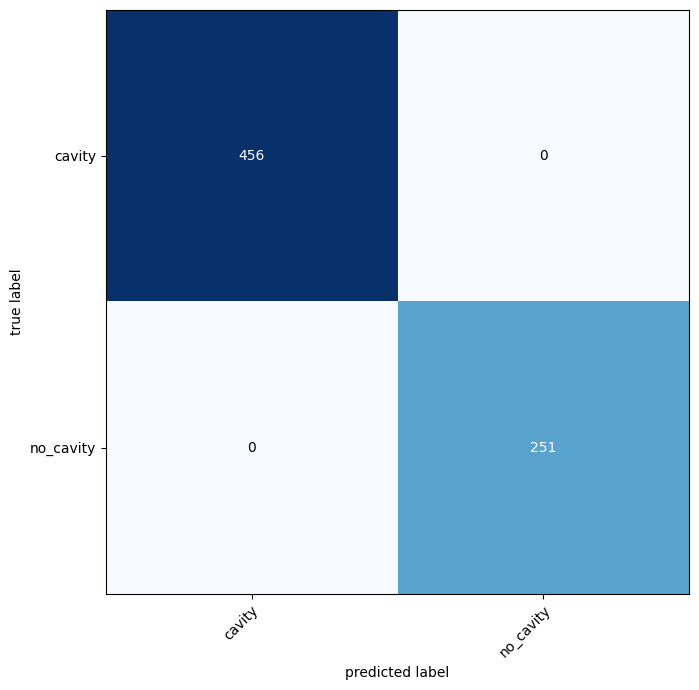

In [310]:
confmat = ConfusionMatrix(task='binary',num_classes=2)
confmat_tensor = confmat(preds = y_pred_tensor, target = true_y.to(device='cpu'))
fig,ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=train_data.classes,
    figsize=(10,7)
)

### Possible Reasons for Low Test Accuracy or Overfitting:
1. Model Architecture is Bad
2. Less Data for training
3. We can also see some images are misleading where **actual** value should be different

### Solutions:
1. Use Different Models with bigger size
2. Use More data Augmentation

Since I have not run this notebook in different environment requirenments file can have some unwanted requirenments.

In [344]:
!pip freeze > requirements.txt

# Future Work

## Make Cavity Detection model